In [1]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

# TREx-ATM Inverse Calculation

TREx-ATM is a time-dependent Aurora Transport Model (ATM), designed to leverage and support TREx optical data. TREx-ATM uses the two-stream electron transport code embedded in the GLOW model (Solomon et al., 1988) with ambipolar diffusion to compute the electron transport. It has additional capacity to compute impact ionization, secondary electron production, and impact excitation of neutrals (height resolved). Use of the TREx-ATM model should cite:

- Liang, J., Donovan, E., Jackel, B., Spanswick, E., & Gillies, M. (2016). On the 630nmred-linepulsating aurora: Red-line emission geospace observatory observations and model simulations. Journal of Geophysical Research: Space Physics, 121, 7988–8012. https://doi.org/10.1002/2016JA022901 
- Liang, J., Yang, B., Donovan, E., Burchill, J., & Knudsen, D. (2017). Ionospheric electron heating associated with pulsating auroras: A Swarm survey and model simulation. Journal of Geophysical Research: Space Physics, 122, 8781–8807. https://doi.org/10.1002/2017JA024127

NOTE: As of July 2025, ATM version "2.0" is now the default model version for the inversion calculation method. If you want to use the version '1.0', simply adjust the `atm_model_version` parameter.

# Perform a basic 'inverse' calculation

Using ATM you can also perform inversion calculations to derive various outputs using emission intensities as inputs.

This function works very similarly to the 'forward' function, where-by some inputs are required, some are optional, and outputs are enabled using True/False flags as part of the request.

Please note that the limitations on latitude and longitude range are designed to constrain requests to the targeted region that the TREx optical instrumentation are deployed to, and over Poker Flat. We also note that the model only takes into account data when the optical instruments were operating at 105 degrees solar zenith angle, which is several degrees lower than nominal data acquisition. This ultimately means that the beginning and end of each night have been excluded when deriving the model algorithm.

Full documentation on this function is [in the `inverse()` function documentation](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax/models/atm/index.html#pyaurorax.models.atm.ATMManager.inverse).

<small>
Input notes:

- By default requests are cached. Use the 'no_cache' parameter to disable this functionality
- Timestamp
  - Timestamp is expected to be in UTC
  - Only specific dates are valid at this time. A 400 error will be returned if an unsupported date is requested. If you want to get a date that we have not enabled support for yet, please contact us.
  - the 'Z' character at the end of the timestamp is optional, and will be ignored if it is supplied
- Latitude and longitude
  - Expected to be in geodetic coordinates
  - latitude is currently limited to >=50.0 and <71.5 degrees
  - longitude is currently limited >=-160 and <-75 and degrees
- Units and defaults
  - intensity_4278: Rayleighs, default is 1000.0
  - intensity_5577: Rayleighs, default is 6000.0
  - intensity_6300: Rayleighs, default is 600.0
  - intensity_8446: Rayleighs, default is 400.0
  - precipitation_flux_spectral_type: valid values are "gaussian" or "maxwellian", default is "gaussian"
  - nrlmsis_model_version: valid values are "00" and "2.0", default is "2.0"
</small>

<small>
Output notes:

- output parameter of the request are toggles the enable/disable each field's inclusion in the response
- all output parameters are false by default
- altitude is in kilometers
- energy flux: erg/cm2/s
- characteristic energy: eV
</small>

Exactly like the 'forward' calculations, ATM inverse requests work in a way where you toggle ON whatever outputs you want back. This allows you to get back only what you want. This mechanism is controlled by the `ATMInverseOutputFlags()` class that must be instantiated before making the calculation.

As part of this class, there are helper functions that toggle all ON or OFF.

!!! Important !!!

A few caveats to keep in mind:

1. Solar photoelectron contribution (i.e., dayglow) is considered in the forward model but mot in the inverse. The user is responsible for ensuring the optical observational inputs used are free of dayglow contamination.
2. The user should appropriately consider the atmospheric attenuation of the auroral lights before using them for inversion. For relevant procedures and recommend parameters, see Liang et al. (2024; 2025).

If you have any questions, please reach out to the UCalgary team.

In [2]:
# set up our request
#
# just like the forward function, outputs are toggled on/off using a flag object.
timestamp = datetime.datetime(2021, 11, 4, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

intensity_4278 = 2302.6
intensity_5577 = 11339.5
intensity_6300 = 528.3
intensity_8446 = 427.4

output = pyaurorax.models.ATMInverseOutputFlags()
output.set_all_true()

In [3]:
# perform the calculation
result = aurorax.models.atm.inverse(timestamp, latitude, longitude, intensity_4278, intensity_5577, intensity_6300, intensity_8446, output)

# let's view the output values we asked for
print("Energy Flux:                %.03f erg/cm2/s" % (result.energy_flux))
print("Characteristic Energy:      %.03f eV" % (result.characteristic_energy))
print("Oxygen Correction Factor:   %.03f" % (result.oxygen_correction_factor))


Energy Flux:                9.044 erg/cm2/s
Characteristic Energy:      4641.122 eV
Oxygen Correction Factor:   0.498


In [4]:
# you can see a nice print of the returned data using the pretty_print() function
result.pretty_print()

ATMInverseResult:
  characteristic_energy     : 4641.121582
  energy_flux               : 9.044496
  oxygen_correction_factor  : 0.498428


# Inverse calculation and perform a subsequent forward calculation

You can take the inversion results and feed those back into a subsequent forward calculation if you want. This used to happen by default for ATM model version 1.0, but now with version 2.0 it is a separate action. This is because the v2.0 forward calculation capabilities have become significantly more customizable.

For the below example, we're going to also change the precipitation flux spectral type to maxwellian, just to illustrate that either 'gaussian' or 'maxwellian' can be used.

In [5]:
# set up parameters
timestamp = datetime.datetime(2021, 11, 4, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

intensity_4278 = 2302.6
intensity_5577 = 11339.5
intensity_6300 = 528.3
intensity_8446 = 427.4

# set output flags
output = pyaurorax.models.ATMInverseOutputFlags()
output.set_all_true()

# perform calculation
result_inverse = aurorax.models.atm.inverse(
    timestamp,
    latitude,
    longitude,
    intensity_4278,
    intensity_5577,
    intensity_6300,
    intensity_8446,
    output,
    precipitation_flux_spectral_type="maxwellian",
)

# show result object
result_inverse.pretty_print()

ATMInverseResult:
  characteristic_energy     : 2581.970215
  energy_flux               : 9.067126
  oxygen_correction_factor  : 0.550006


Now do the forward calculation using the energy flux and characteristic energy for the maxwellian inputs.

In [6]:
# set up inputs
output = pyaurorax.models.ATMForwardOutputFlags()
output.set_all_true()  # we're going to ask for everything that the forward function provides

# perform the calculation
result_forward = aurorax.models.atm.forward(
    timestamp,
    latitude,
    longitude,
    output,
    maxwellian_energy_flux=result.energy_flux,
    maxwellian_characteristic_energy=result.characteristic_energy,
)

# view the output
#
# we use handy print method for the results
result_forward.pretty_print()

ATMForwardResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                        : array([2.55064265e-06, 5.06039851e-06, 5.43968126e-05, 4.312 ...])
  emission_1356                        : array([4.14739645e-07, 8.67755602e-07, 9.33383035e-06, 7.400 ...])
  emission_4278                        : array([2.09988933e-02, 1.55480038e-02, 6.32785931e-02, 1.888 ...])
  emission_5577                        : array([1.58069335e-04, 1.06265012e-03, 1.28615666e-02, 1.514 ...])
  emission_6300                        : array([3.56912011e-07, 3.46423576e-07, 1.48605397e-06, 5.488 ...])
  emission_8446                        : array([9.15687679e-07, 1.83192026e-06, 1.96981764e-05, 1.561 ...])
  emission_lbh                         : array([6.54690042e-02, 5.50122298e-02, 2.23922744e-01, 6.683 ...])
  height_integrated_rayleighs_1304     : 1350.634370
  height_integrated_rayleighs_1356     : 236.840748
  height_inte

Energy Flux:                9.067 erg/cm2/s
Characteristic Energy:      2581.970 eV
Oxygen Correction Factor:   0.550

Height-integrated Rayleighs:
  427.8nm:  2254.81 R
  557.7nm:  15067.10 R
  630.0nm:  247.38 R
  844.6nm:  491.66 R


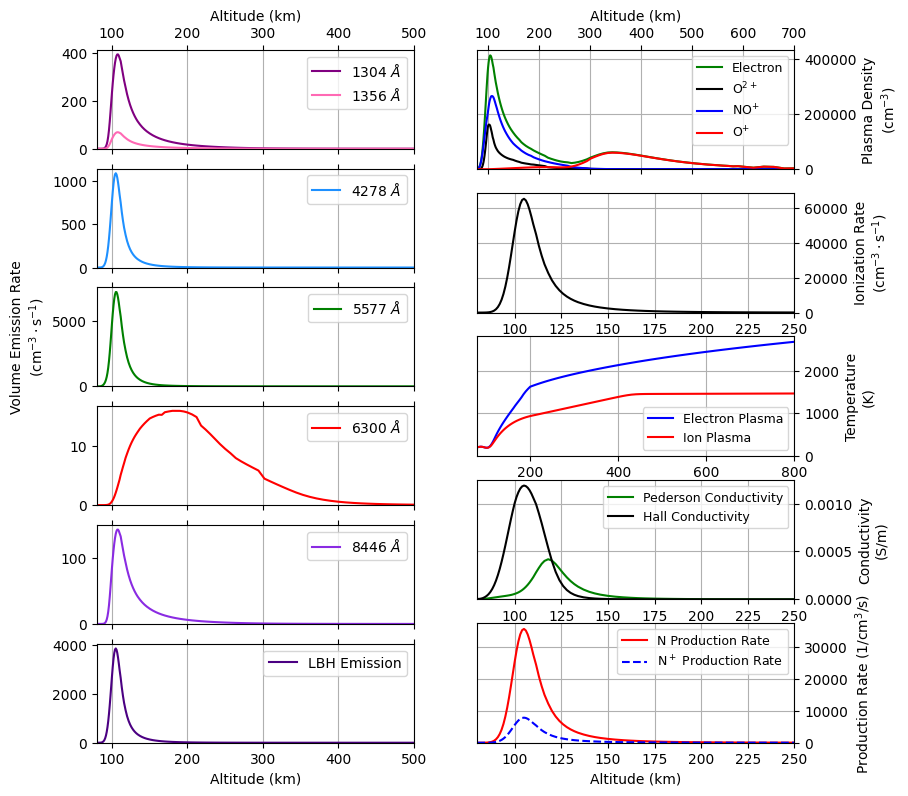

In [8]:
# print the energy flux, characteristic energy, and oxygen correction factor
print("Energy Flux:                %.03f erg/cm2/s" % (result_inverse.energy_flux))
print("Characteristic Energy:      %.03f eV" % (result_inverse.characteristic_energy))
print("Oxygen Correction Factor:   %.03f\n" % (result_inverse.oxygen_correction_factor))

# print all height-integrated Rayleighs data
print("""Height-integrated Rayleighs:
  427.8nm:  %.02f R
  557.7nm:  %.02f R
  630.0nm:  %.02f R
  844.6nm:  %.02f R""" % (result_forward.height_integrated_rayleighs_4278, result_forward.height_integrated_rayleighs_5577,
                          result_forward.height_integrated_rayleighs_6300, result_forward.height_integrated_rayleighs_8446))

# plot the emission, plasma, and neutral data
#
# we'll do this all in one plot, but made up from many subplots
alt = result_forward.altitudes
fig = plt.figure(figsize=(9, 9))

# plot all the emissions as a column of subplots
#
# 1304 A & 1356 A emission
ax1 = fig.add_subplot(6, 2, 1)
ax1.plot(alt, result_forward.emission_1304, label=r"1304 $\AA$", color="purple")
ax1.plot(alt, result_forward.emission_1356, label=r"1356 $\AA$", color="hotpink")
ax1.legend()
ax1.set_xlim(80, 500)
ax1.set_ylim(bottom=0)
ax1.grid(axis="x")
ax1.set_xlabel("Altitude (km)", va="bottom")
ax1.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax1.xaxis.set_label_position("top")

# blueline emission
ax2 = fig.add_subplot(6, 2, 3)
ax2.plot(alt, result_forward.emission_4278, label=r"4278 $\AA$", color="dodgerblue")
ax2.legend()
ax2.set_xlim(80, 500)
ax2.set_ylim(bottom=0)
ax2.grid(axis="x")
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# greenline emission
ax3 = fig.add_subplot(6, 2, 5)
ax3.plot(alt, result_forward.emission_5577, label=r"5577 $\AA$", color="green")
ax3.legend()
ax3.set_xlim(80, 500)
ax3.set_ylim(bottom=0)
ax3.grid(axis="x")
ax3.set_ylabel("Volume Emission Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax3.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# redline emission
ax4 = fig.add_subplot(6, 2, 7)
ax4.plot(alt, result_forward.emission_6300, label=r"6300 $\AA$", color="red")
ax4.legend()
ax4.set_xlim(80, 500)
ax4.set_ylim(bottom=0)
ax4.grid(axis="x")
ax4.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# near-infrared 8446 A emission
ax5 = fig.add_subplot(6, 2, 9)
ax5.plot(alt, result_forward.emission_8446, label=r"8446 $\AA$", color="blueviolet")
ax5.legend()
ax5.set_xlim(80, 500)
ax5.set_ylim(bottom=0)
ax5.grid(axis="x")
ax5.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# Lyman-Birge-Hopfield emission
ax6 = fig.add_subplot(6, 2, 11)
ax6.plot(alt, result_forward.emission_lbh, label="LBH Emission", color="indigo")
ax6.legend()
ax6.set_xlim(80, 500)
ax6.set_ylim(bottom=0)
ax6.grid(axis="x")
ax6.set_xlabel("Altitude (km)")
ax6.tick_params(axis="x", bottom=True, top=True)

# plot the plasma data as a second column of subplots
#
# plasma density
ax7 = fig.add_subplot(5, 2, 2)
ax7.plot(alt, result_forward.plasma_electron_density, label="Electron", color="green")
ax7.plot(alt, result_forward.plasma_o2plus_density, label="O$^{2+}$", color="black")
ax7.plot(alt, result_forward.plasma_noplus_density, label="NO$^{+}$", color="blue")
ax7.plot(alt, result_forward.plasma_oplus_density, label="O$^{+}$", color="red")
ax7.grid()
ax7.set_ylabel("Plasma Density\n(cm$^{-3}$)")
ax7.legend(fontsize=9)
ax7.set_xlim(80, 700)
ax7.set_ylim(bottom=0)
ax7.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax7.set_xlabel("Altitude (km)")
ax7.xaxis.set_label_position("top")
ax7.yaxis.set_label_position("right")
ax7.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma ionisation rate
ax8 = fig.add_subplot(5, 2, 4)
ax8.plot(alt, result_forward.plasma_ionisation_rate, color="black")
ax8.grid()
ax8.set_ylabel("Ionization Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax8.set_xlim(80, 250)
ax8.set_ylim(bottom=0)
ax8.yaxis.set_label_position("right")
ax8.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma temperatures
ax9 = fig.add_subplot(5, 2, 6)
ax9.plot(alt, result_forward.plasma_electron_temperature, label="Electron Plasma", color="blue")
ax9.plot(alt, result_forward.plasma_ion_temperature, label="Ion Plasma", color="red")
ax9.grid()
ax9.legend(fontsize=9)
ax9.set_ylabel("Temperature\n(K)")
ax9.set_xlim(80, 800)
ax9.set_ylim(bottom=0)
ax9.yaxis.set_label_position("right")
ax9.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma conductivities
ax10 = fig.add_subplot(5, 2, 8)
ax10.plot(alt, result_forward.plasma_pederson_conductivity, label="Pederson Conductivity", color="green")
ax10.plot(alt, result_forward.plasma_hall_conductivity, label="Hall Conductivity", color="black")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Conductivity\n(S/m)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# some production rates
ax10 = fig.add_subplot(5, 2, 10)
ax10.plot(alt, result_forward.production_rate_n, label="N Production Rate", color="red")
ax10.plot(alt, result_forward.production_rate_nplus, label="N$^+$ Production Rate", color="blue", linestyle="--")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Production Rate (1/cm$^3$/s)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# render the plot
plt.show()